In [1]:
# import plumed
import matplotlib.pyplot as plt
import os
# import MDAnalysis

In [2]:
# set working directory for all future cells
os.chdir("/home/yamin/Project/Proj23")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()

/home/yamin/Project/Proj23


'/home/yamin/Project/Proj23'

In [3]:
%%bash
cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step temp pe ke press density vol enthalpy atoms lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} restart/restart.\${temperature}.\${p_id} #restart2.\${p_id}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} dump_\${temperature}.lammpstrj
    dump_modify  myDump append yes
EOF

# NVT
### we preform an NVT integration: 
First an energy minimization procedure is applied, adjusting the atoms coordinates until one of these stopping criteria is met:
The change in energy between two iterations is less than 1.0e-4,
- The change in energy between two iterations is less than 1.0e-4,
- The maximum force between two atoms in the system is lower than 1.0e-6,
- The maximum number of iterations is 1000,
- The maximum number of times the force and the energy have been evaluated is 10000.

Next, we perform a temperature adjustment using a canonical sampling thermostat. the thermostat is similar to the empirical Berendsen thermostat in temp/berendsen, but chooses the actual scaling factor from a suitably chosen (gaussian) distribution rather than having it determined from the time constant directly.

Unlike the fix nvt command which performs Nose/Hoover thermostatting and time integration, these fixes do not perform time integration. They only modify velocities to effect thermostatting. Thus we must use a separate time integration fix, the fix nve to actually update the positions of atoms using the modified velocities. the velocities are updated using a random number generator at the chosen temprature.

In [4]:
%%bash
cat > "start_temp.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/temp/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           2
run             5000
unfix           1

# neigh_modify every 1 delay 5 check yes

EOF


In [5]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_temp.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (23 Jun 2022 - Update 4)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogon

      2000   280.94486     -258.59221      9.0424282     -2354.9087      0.89630466     10648         -265.20041            250   22             22             22             0              0              0             -3371.8874     -2049.0985     -1643.74       -8.8260409     -467.28085     -327.36992    
      2500   321.23314     -257.96702      10.339138     -2062.6635      0.89630466     10648         -261.33625            250   22             22             22             0              0              0             -2567.3341     -1412.8945     -2207.7619      352.20002     -114.65695     -123.30044    
      3000   295.8111      -258.75725      9.5209098     -2386.4554      0.89630466     10648         -265.09663            250   22             22             22             0              0              0             -2576.3003     -2338.9737     -2244.0921      293.84233      191.86051     -241.5142     
      3500   294.43826     -258.99558      9.4767241     -2481.549       

     15500   264.07177     -258.83174      8.4993547     -2470.5761      0.89630466     10648         -266.75173            250   22             22             22             0              0              0             -3172.4749     -1891.3202     -2347.9332     -22.538664     -375.87454     -141.83894    
     16000   310.62337     -259.67907      9.9976543     -2540.3367      0.89630466     10648         -266.56439            250   22             22             22             0              0              0             -2758.6068     -2361.2667     -2501.1366     -202.87794      36.508873     -71.315868    
     16500   275.04422     -259.28629      8.8525117     -2449.0613      0.89630466     10648         -266.71014            250   22             22             22             0              0              0             -2132.2524     -2947.8926     -2267.039      -46.270127      334.86015     -240.48985    
     17000   337.37551     -258.30382      10.858693     -1991.5561      

     25500   315.86409     -258.07394      10.166331     -2051.4153      0.89630466     10648         -261.54124            250   22             22             22             0              0              0             -1356.4433     -2378.2987     -2419.5039      248.83761     -313.85506     -121.94299    
     26000   309.42644     -257.86702      9.9591303     -1964.5293      0.89630466     10648         -260.96407            250   22             22             22             0              0              0             -1807.992      -1832.9202     -2252.6759     -46.234054     -43.575216     -347.995      
     26500   316.4548      -258.09297      10.185343     -2118.2473      0.89630466     10648         -261.98541            250   22             22             22             0              0              0             -2333.0182     -2216.0531     -1805.6705      131.51655      173.42783     -73.43216     
     27000   294.09789     -257.37329      9.4657688     -2022.0284      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.013213   | 0.013213   | 0.013213   |   0.0 | 80.19
Bond    | 1.611e-06  | 1.611e-06  | 1.611e-06  |   0.0 |  0.01
Neigh   | 0.0026941  | 0.0026941  | 0.0026941  |   0.0 | 16.35
Comm    | 0.00024801 | 0.00024801 | 0.00024801 |   0.0 |  1.51
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003195  |            |       |  1.94

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   336.38224     -257.98625      10.826724     -2014.8125      0.89630466     10648         -260.54989            250   22             22             22             0              0              0             -2354.1872     -1510.6784     -2179.5721      347.26247      162.85066      146.25516    
      9000   322.032       -257.11789      10.36485      -1848.0895      0.89630466     10648         -259.03537            250   22             22             22             0              0              0             -1733.1598     -1760.8989     -2050.2099      97.65077      -227.68602     -816.71898    
      9500   314.48831     -256.96962      10.12205      -1754.2492      0.89630466     10648         -258.50624            250   22             22             22             0              0              0             -2116.7154     -965.9151      -2180.1171      222.35133     -231.32359     -464.83465    
     10000   330.44541     -257.03285      10.635642     -1735.9243      

     22000   322.66121     -256.6117       10.385101     -1706.6244      0.89630466     10648         -257.56876            250   22             22             22             0              0              0             -2057.0404     -1435.5742     -1627.2586     -198.53316      239.15393     -284.2683     
     22500   341.69808     -257.8139       10.997818     -2076.6343      0.89630466     10648         -260.61731            250   22             22             22             0              0              0             -1730.2896     -2273.7259     -2225.8874     -25.673303     -167.33378     -397.34368    
     23000   316.3161      -257.70752      10.180879     -1859.798       0.89630466     10648         -259.88678            250   22             22             22             0              0              0             -2065.5706     -1359.3142     -2154.5093      3.7367575     -234.64151      126.79278    
     23500   338.21947     -257.41662      10.885856     -1944.0147      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.019741   | 0.019741   | 0.019741   |   0.0 | 83.98
Bond    | 2.385e-06  | 2.385e-06  | 2.385e-06  |   0.0 |  0.01
Neigh   | 0.0030651  | 0.0030651  | 0.0030651  |   0.0 | 13.04
Comm    | 0.00027835 | 0.00027835 | 0.00027835 |   0.0 |  1.18
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004186  |            |       |  1.78

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   345.91442     -257.55486      11.133524     -1739.1265      0.89630466     10648         -257.9795             250   22             22             22             0              0              0             -2253.763      -827.80799     -2135.8085      44.571767      1.4884544     -591.08394    
      9000   339.15286     -256.48495      10.915898     -1562.6469      0.89630466     10648         -255.95434            250   22             22             22             0              0              0             -1312.2495     -1379.8803     -1995.8109     -395.08021     -532.72416     -261.42116    
      9500   378.75889     -257.98116      12.190649     -1956.0187      0.89630466     10648         -258.79014            250   22             22             22             0              0              0             -2324.9473     -1935.9432     -1607.1656     -693.84038     -162.42833     -112.42341    
     10000   352.9547      -256.62694      11.360121     -1581.6524      

     22000   356.97384     -257.01666      11.48948      -1674.3794      0.89630466     10648         -256.65504            250   22             22             22             0              0              0             -558.83969     -1973.0325     -2491.2661      696.51894     -183.76366      46.318535    
     22500   355.38573     -256.28314      11.438365     -1399.3525      0.89630466     10648         -254.14481            250   22             22             22             0              0              0             -1385.9958     -1611.3475     -1200.7141      5.8482126     -432.25611     -232.09442    
     23000   347.94624     -256.69133      11.19892      -1755.4856      0.89630466     10648         -257.1593             250   22             22             22             0              0              0             -1414.3017     -2052.3972     -1799.7578     -375.7739      -885.16761      609.50054    
     23500   367.59943     -255.94234      11.831473     -1298.8578      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.015526   | 0.015526   | 0.015526   |   0.0 | 82.44
Bond    | 1.648e-06  | 1.648e-06  | 1.648e-06  |   0.0 |  0.01
Neigh   | 0.0027248  | 0.0027248  | 0.0027248  |   0.0 | 14.47
Comm    | 0.0002423  | 0.0002423  | 0.0002423  |   0.0 |  1.29
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.000338   |            |       |  1.79

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   372.1379      -255.7339       11.977547     -1337.9604      0.89630466     10648         -252.64838            250   22             22             22             0              0              0             -1233.7843     -1659.584      -1120.5129      172.87959      748.05622     -166.61884    
      9000   383.80501     -256.33951      12.353062     -1260.2748      0.89630466     10648         -252.36219            250   22             22             22             0              0              0             -1467.9904     -1117.5577     -1195.2762      57.444884     -417.92675      44.273039    
      9500   366.22007     -255.0286       11.787077     -1052.5344      0.89630466     10648         -250.23662            250   22             22             22             0              0              0             -1555.616      -522.63695     -1079.3503      37.226407      488.47386     -355.40077    
     10000   365.55055     -254.93337      11.765528     -870.57905      

     22000   373.4618      -255.06281      12.020158     -1066.749       0.89630466     10648         -250.13223            250   22             22             22             0              0              0             -830.36976     -1070.102      -1299.7754      781.88765      136.0691      -235.64271    
     22500   373.06472     -254.99769      12.007378     -850.53592      0.89630466     10648         -248.64294            250   22             22             22             0              0              0             -836.34118     -1057.378      -657.88859     -73.805391      30.294456     -68.590955    
     23000   360.5428      -256.57115      11.60435      -1411.2017      0.89630466     10648         -254.34559            250   22             22             22             0              0              0             -1747.0953     -1772.0005     -714.50944     -834.53679      155.12703      217.69164    
     23500   389.53366     -255.1371       12.537443     -1011.2343      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.013217   | 0.013217   | 0.013217   |   0.0 | 79.32
Bond    | 1.838e-06  | 1.838e-06  | 1.838e-06  |   0.0 |  0.01
Neigh   | 0.0028469  | 0.0028469  | 0.0028469  |   0.0 | 17.09
Comm    | 0.00024899 | 0.00024899 | 0.00024899 |   0.0 |  1.49
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003476  |            |       |  2.09

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   406.78282     -255.45719      13.092621     -1201.0135      0.89630466     10648         -250.34645            250   22             22             22             0              0              0             -576.89072     -1247.412      -1778.7377     -541.88969      26.171275     -456.15858    
      9000   411.20719     -254.85045      13.235022     -768.37428      0.89630466     10648         -246.72201            250   22             22             22             0              0              0             -1118.0324     -535.9264      -651.16404      121.63485     -366.44634     -93.549298    
      9500   416.21653     -256.12786      13.396252     -1170.7262      0.89630466     10648         -250.51221            250   22             22             22             0              0              0             -998.28063     -1873.8283     -640.06965     -8.4773907     -304.91713      544.60815    
     10000   425.26825     -254.8171       13.687589     -787.73525      

     22000   422.43716     -254.9356       13.596468     -815.55314      0.89630466     10648         -246.75926            250   22             22             22             0              0              0             -1402.7546     -141.20022     -902.70465     -652.10461     -305.04021      154.28971    
     22500   411.56797     -254.60927      13.246635     -735.95867      0.89630466     10648         -246.25378            250   22             22             22             0              0              0             -925.42524     -712.85579     -569.595       -245.16779     -240.00585      395.36554    
     23000   401.02889     -255.51487      12.907426     -1144.5995      0.89630466     10648         -250.21441            250   22             22             22             0              0              0             -1155.9593     -1423.56       -854.27921     -466.43734     -97.931258     -140.94981    
     23500   425.72022     -254.54666      13.702136     -868.66355      

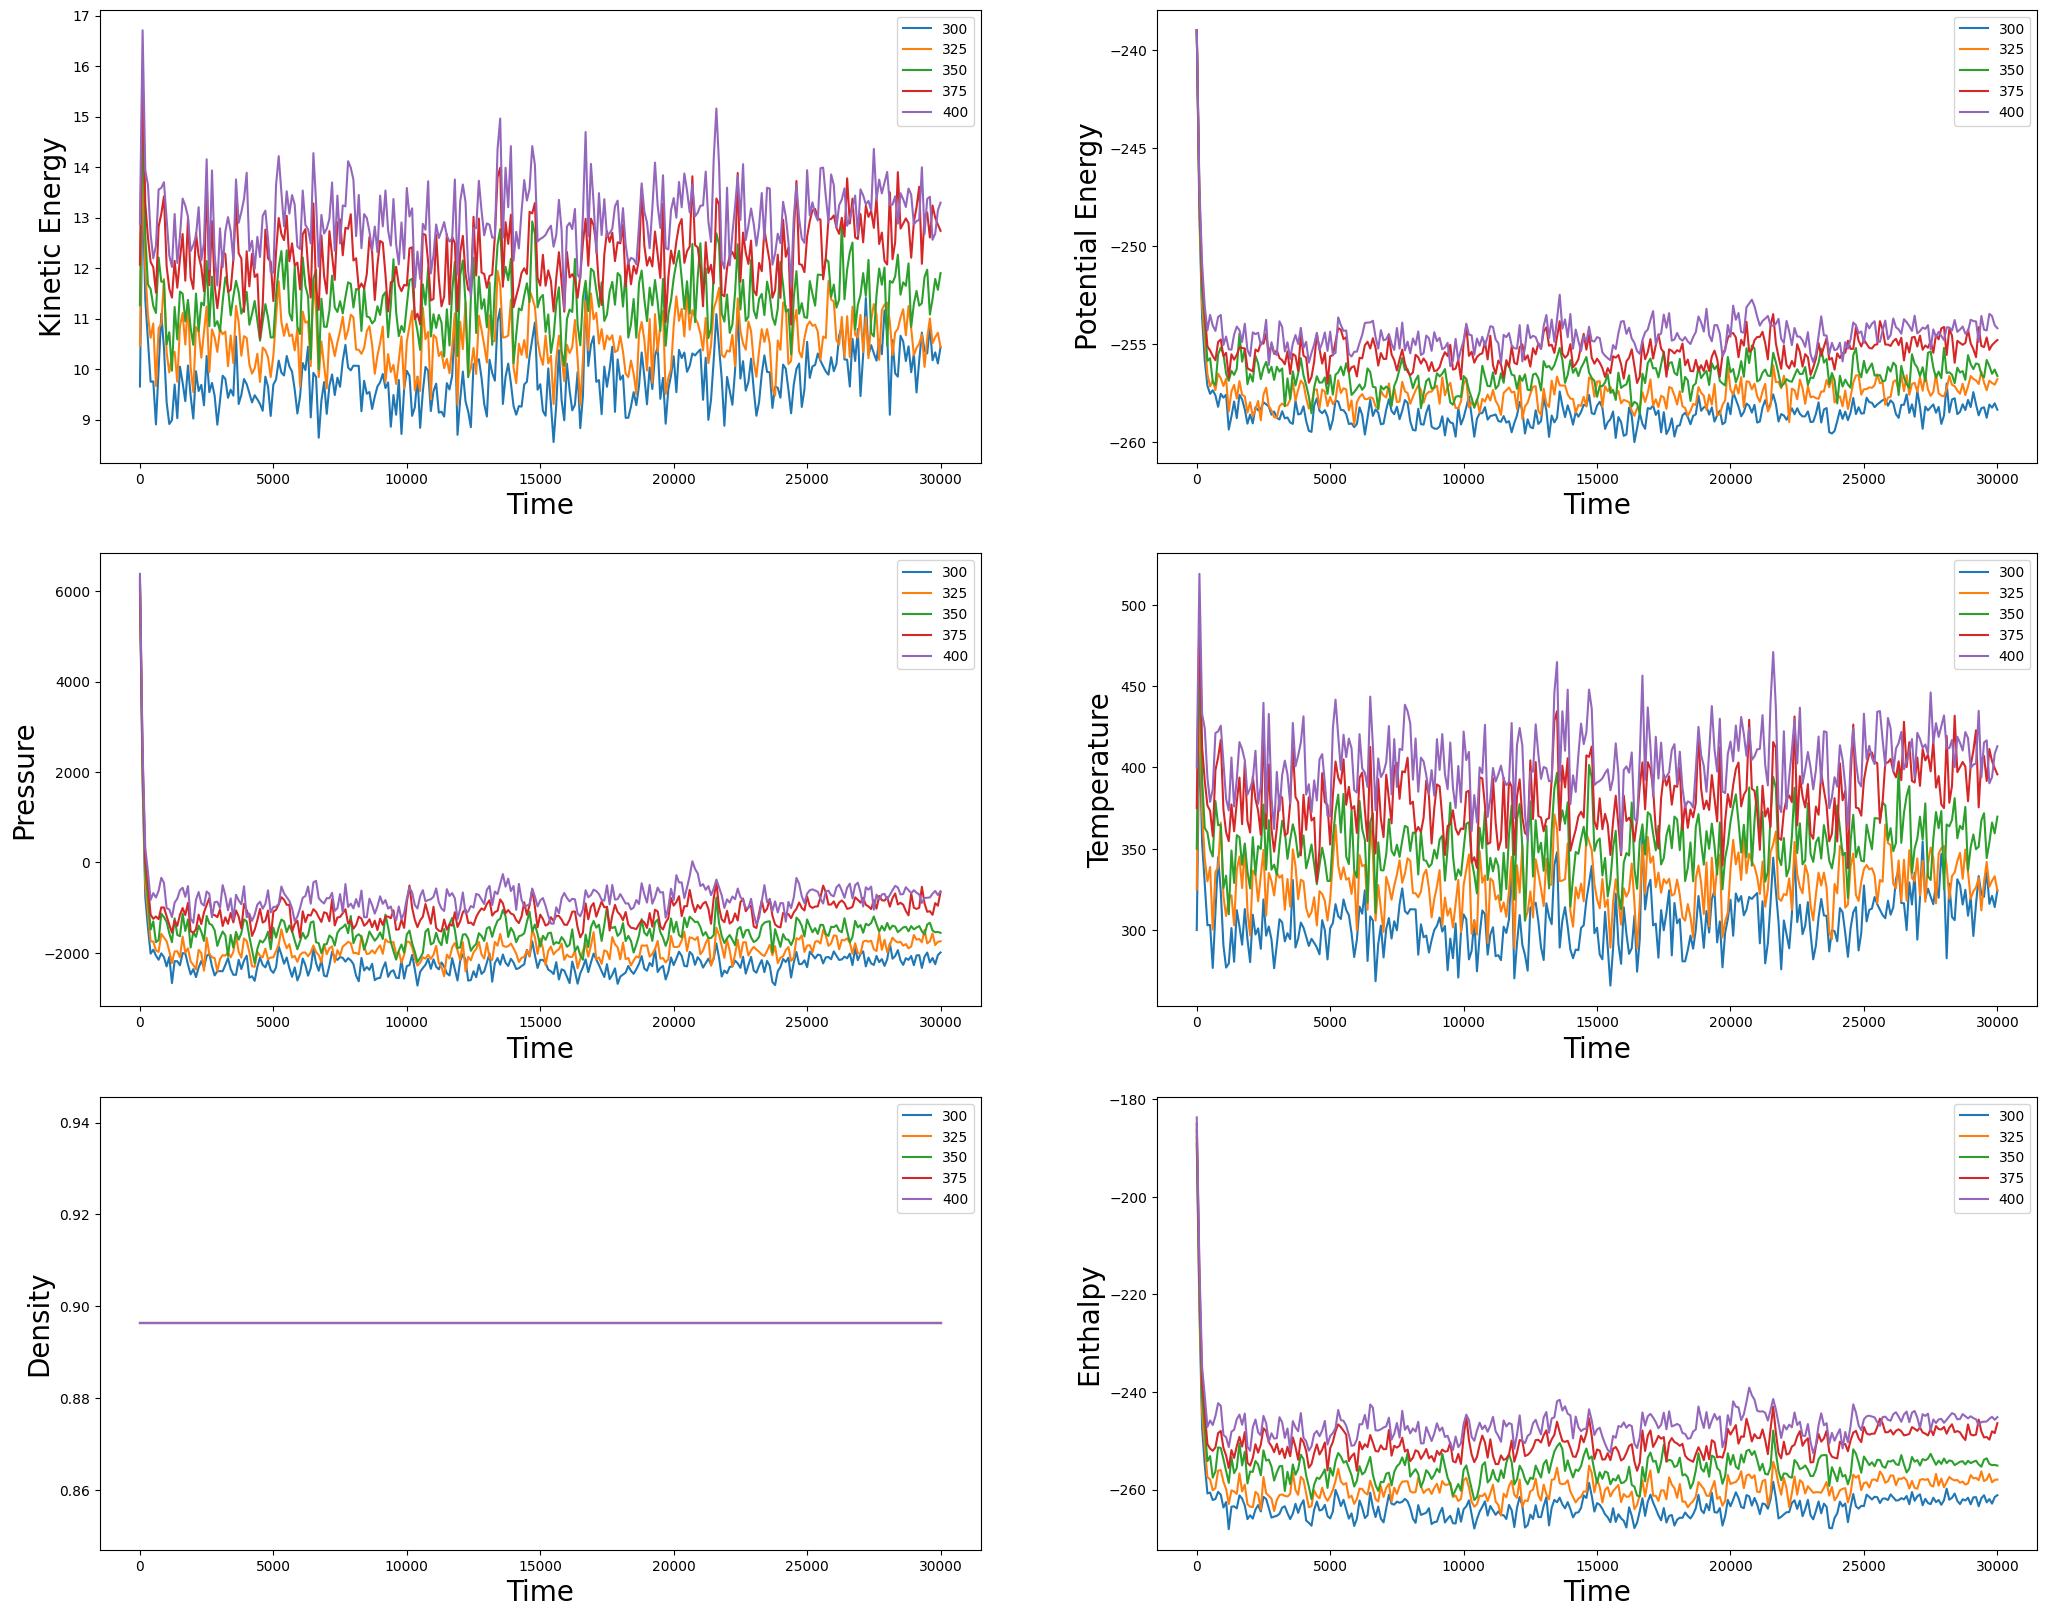

In [6]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/temp/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 20))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][::10]), energy[tmp].T[n+1][::10], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [227]:
energy[tmp].T[0][0]

0.0

# NVT-2
A different NVT integration can be done using the Nose-Hoover style non-Hamiltonian equations of motion, 
sampling from an isenthalpic ensemble (at a speicific enthalpy). This is done by fixing a desired pressure value over which a time scale factor of relaxation pressure, pressureDamp is defined.
if pdamp is too small, pressure can oscilate widely. if pdamp is too big the system will take a long time to equilibrate.
Temperature is adjusted using a canonical sampling thermostat that uses global velocity rescaling.

In [222]:
%%bash
cat > "start_press.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/press/energy\${temperature}.dat


fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

fix             3 all nve
run             5000
unfix           3

# neigh_modify every 1 delay 5 check yes

EOF


In [223]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_press.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   10500    280.18577   -267.37386    9.0179964   -151.23421    0.9545838    9997.9195    -259.2996      250    21.542853    21.542853    21.542853            0            0            0   -304.55942    38.176321   -187.31954    167.51965    130.10014    305.52808 
   11000    305.24479   -267.47738    9.8245404    531.88687   0.96387426    9901.5529   -254.36574      250    21.473414    21.473414    21.473414            0            0            0    636.34494    521.45861    437.85705    294.33976    127.83868    129.89278 
   11500     298.6457    -267.3569    9.6121435    139.84716   0.96051833    9936.1476   -256.87747      250    21.498394    21.498394    21.498394            0            0            0    239.28802   -37.390332    217.64378    382.76228    48.939886    230.41792 
   12000    319.34719   -267.79711    10.278437    -392.3471   0.95130164    10032.414   -259.97544      250      21.5676      21.5676      21.5676            0            0            0   -192.65835   

---------------------------------------------------------------
Pair    | 8.1631     | 8.1631     | 8.1631     |   0.0 | 91.56
Bond    | 0.0017627  | 0.0017627  | 0.0017627  |   0.0 |  0.02
Neigh   | 0.41601    | 0.41601    | 0.41601    |   0.0 |  4.67
Comm    | 0.10716    | 0.10716    | 0.10716    |   0.0 |  1.20
Output  | 0.0012369  | 0.0012369  | 0.0012369  |   0.0 |  0.01
Modify  | 0.19718    | 0.19718    | 0.19718    |   0.0 |  2.21
Other   |            | 0.02958    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1924.00 ave        1924 max        1924 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        18787.0 ave       18787 max       18787 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 18787
Ave neighs/atom = 75.148000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 565
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.014134   | 0.014134   | 0.014134   |   0.0 | 78.47
Bond    | 2.978e-06  | 2.978e-06  | 2.978e-06  |   0.0 |  0.02
Neigh   | 0.0031791  | 0.0031791  | 0.0031791  |   0.0 | 17.65
Comm    | 0.00028159 | 0.00028159 | 0.00028159 |   0.0 |  1.56
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004147  |            |       |  2.30

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

---------------------------------------------------------------
Pair    | 8.1609     | 8.1609     | 8.1609     |   0.0 | 91.95
Bond    | 0.0013209  | 0.0013209  | 0.0013209  |   0.0 |  0.01
Neigh   | 0.41201    | 0.41201    | 0.41201    |   0.0 |  4.64
Comm    | 0.098674   | 0.098674   | 0.098674   |   0.0 |  1.11
Output  | 0.0011721  | 0.0011721  | 0.0011721  |   0.0 |  0.01
Modify  | 0.17138    | 0.17138    | 0.17138    |   0.0 |  1.93
Other   |            | 0.02951    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1882.00 ave        1882 max        1882 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        18159.0 ave       18159 max       18159 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 18159
Ave neighs/atom = 72.636000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 590
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011776   | 0.011776   | 0.011776   |   0.0 | 78.36
Bond    | 1.853e-06  | 1.853e-06  | 1.853e-06  |   0.0 |  0.01
Neigh   | 0.0026358  | 0.0026358  | 0.0026358  |   0.0 | 17.54
Comm    | 0.00023347 | 0.00023347 | 0.00023347 |   0.0 |  1.55
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003806  |            |       |  2.53

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

---------------------------------------------------------------
Pair    | 8.1275     | 8.1275     | 8.1275     |   0.0 | 91.36
Bond    | 0.0018216  | 0.0018216  | 0.0018216  |   0.0 |  0.02
Neigh   | 0.44348    | 0.44348    | 0.44348    |   0.0 |  4.98
Comm    | 0.10346    | 0.10346    | 0.10346    |   0.0 |  1.16
Output  | 0.0012039  | 0.0012039  | 0.0012039  |   0.0 |  0.01
Modify  | 0.18805    | 0.18805    | 0.18805    |   0.0 |  2.11
Other   |            | 0.03095    |            |       |  0.35

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1842.00 ave        1842 max        1842 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17828.0 ave       17828 max       17828 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17828
Ave neighs/atom = 71.312000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012663   | 0.012663   | 0.012663   |   0.0 | 76.55
Bond    | 1.991e-06  | 1.991e-06  | 1.991e-06  |   0.0 |  0.01
Neigh   | 0.0031736  | 0.0031736  | 0.0031736  |   0.0 | 19.18
Comm    | 0.00025608 | 0.00025608 | 0.00025608 |   0.0 |  1.55
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004483  |            |       |  2.71

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

---------------------------------------------------------------
Pair    | 8.1252     | 8.1252     | 8.1252     |   0.0 | 91.31
Bond    | 0.0014213  | 0.0014213  | 0.0014213  |   0.0 |  0.02
Neigh   | 0.45461    | 0.45461    | 0.45461    |   0.0 |  5.11
Comm    | 0.10441    | 0.10441    | 0.10441    |   0.0 |  1.17
Output  | 0.0012828  | 0.0012828  | 0.0012828  |   0.0 |  0.01
Modify  | 0.18241    | 0.18241    | 0.18241    |   0.0 |  2.05
Other   |            | 0.02888    |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1834.00 ave        1834 max        1834 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17717.0 ave       17717 max       17717 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17717
Ave neighs/atom = 70.868000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 645
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011764   | 0.011764   | 0.011764   |   0.0 | 78.21
Bond    | 1.94e-06   | 1.94e-06   | 1.94e-06   |   0.0 |  0.01
Neigh   | 0.0026979  | 0.0026979  | 0.0026979  |   0.0 | 17.94
Comm    | 0.00023938 | 0.00023938 | 0.00023938 |   0.0 |  1.59
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003379  |            |       |  2.25

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

---------------------------------------------------------------
Pair    | 8.1148     | 8.1148     | 8.1148     |   0.0 | 91.28
Bond    | 0.0014575  | 0.0014575  | 0.0014575  |   0.0 |  0.02
Neigh   | 0.46126    | 0.46126    | 0.46126    |   0.0 |  5.19
Comm    | 0.10264    | 0.10264    | 0.10264    |   0.0 |  1.15
Output  | 0.001198   | 0.001198   | 0.001198   |   0.0 |  0.01
Modify  | 0.17999    | 0.17999    | 0.17999    |   0.0 |  2.02
Other   |            | 0.02881    |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1822.00 ave        1822 max        1822 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17669.0 ave       17669 max       17669 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17669
Ave neighs/atom = 70.676000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 669
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

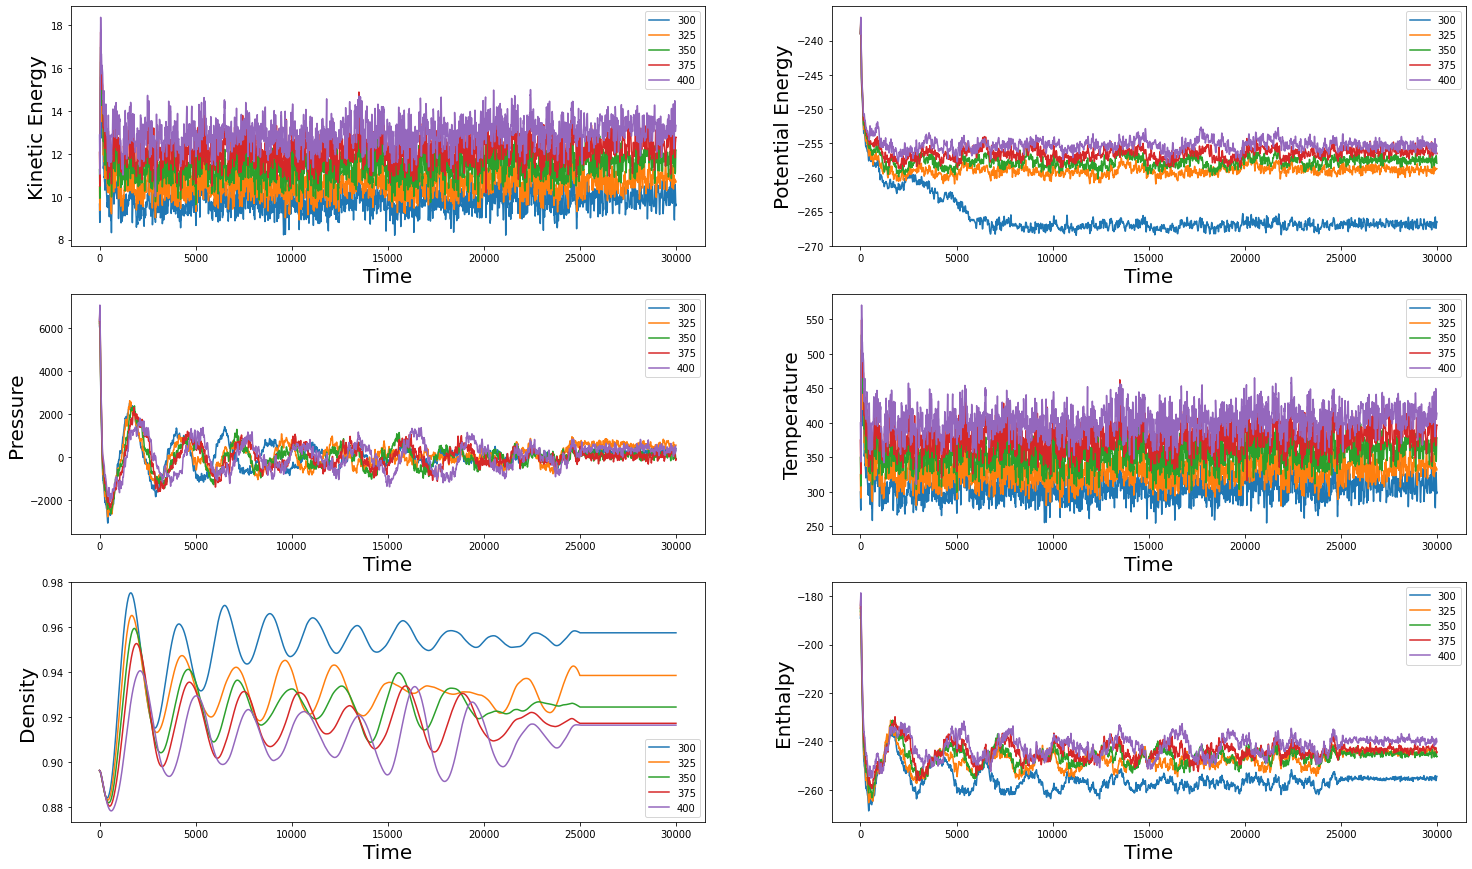

In [229]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/press/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][:]), energy[tmp].T[n+1][:], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



# NVT + NPH
The article use both methods to reach equilibration

In [7]:
%%bash
cat > "start_temp_press.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/temp_press/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

# fix             1 all nve
# run             5000
# unfix           1

# neigh_modify every 1 delay 5 check yes

EOF

In [8]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_temp_press.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (23 Jun 2022 - Update 4)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogon

      2000   280.94486     -258.59221      9.0424282     -2354.9087      0.89630466     10648         -265.20041            250   22             22             22             0              0              0             -3371.8874     -2049.0985     -1643.74       -8.8260409     -467.28085     -327.36992    
      2500   321.23314     -257.96702      10.339138     -2062.6635      0.89630466     10648         -261.33625            250   22             22             22             0              0              0             -2567.3341     -1412.8945     -2207.7619      352.20002     -114.65695     -123.30044    
      3000   295.8111      -258.75725      9.5209098     -2386.4554      0.89630466     10648         -265.09663            250   22             22             22             0              0              0             -2576.3003     -2338.9737     -2244.0921      293.84233      191.86051     -241.5142     
      3500   294.43826     -258.99558      9.4767241     -2481.549       

     15000   297.70474     -258.13719      9.5818581     -2164.9258      0.89630466     10648         -262.94334            250   22             22             22             0              0              0             -1629.6795     -2522.3397     -2342.7581      409.52963     -406.39566     -74.316642    
     15500   264.07177     -258.83174      8.4993547     -2470.5761      0.89630466     10648         -266.75173            250   22             22             22             0              0              0             -3172.4749     -1891.3202     -2347.9332     -22.538664     -375.87454     -141.83894    
     16000   310.62337     -259.67907      9.9976543     -2540.3367      0.89630466     10648         -266.56439            250   22             22             22             0              0              0             -2758.6068     -2361.2667     -2501.1366     -202.87794      36.508873     -71.315868    
     16500   275.04422     -259.28629      8.8525117     -2449.0613      

  Current step  : 25000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
   Step          Temp          PotEng         KinEng         Press         Density         Volume        Enthalpy       Atoms          Lx             Ly             Lz             Xy             Xz             Yz            Pxx            Pyy            Pzz            Pxy            Pxz            Pyz      
     25000   300           -258.52405      9.6557328     -2402.2472      0.89630466     10648         -264.83356            250   22             22             22             0              0              0             -2479.5544     -2243.891      -2483.296      -52.426632     -6.0184245      326.67069    
     25500   291.31329     -259.35172      9.3761442     -719.68963      0.92369554     10332.249     -254.61677            250   21.780355      21.780355      21.780355      0              0              0             -1349.0729     -688.74361     -121.2523

     37500   293.16582     -260.01368      9.4357693     -203.67541      0.9342226      10215.822     -251.87659            250   21.698237      21.698237      21.698237      0              0              0             -15.892686     -440.22107     -154.91248     -280.10428     -81.741069     -110.41498    
     38000   310.49063     -260.60194      9.9933818      23.461446      0.9385759      10168.439     -250.45966            250   21.664638      21.664638      21.664638      0              0              0              443.22154      31.845995     -404.6832       129.19705      198.72632      217.48336    
     38500   326.09473     -260.16769      10.495612      551.96219      0.94221234     10129.194     -246.1825             250   21.636731      21.636731      21.636731      0              0              0              342.70717      519.62625      793.55313     -537.28333      211.86634     -147.55844    
     39000   273.12574     -260.22412      8.7907641      130.06186      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012321   | 0.012321   | 0.012321   |   0.0 | 78.48
Bond    | 1.562e-06  | 1.562e-06  | 1.562e-06  |   0.0 |  0.01
Neigh   | 0.0026316  | 0.0026316  | 0.0026316  |   0.0 | 16.76
Comm    | 0.00022799 | 0.00022799 | 0.00022799 |   0.0 |  1.45
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0005176  |            |       |  3.30

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   336.38224     -257.98625      10.826724     -2014.8125      0.89630466     10648         -260.54989            250   22             22             22             0              0              0             -2354.1872     -1510.6784     -2179.5721      347.26247      162.85066      146.25516    
      9000   322.032       -257.11789      10.36485      -1848.0895      0.89630466     10648         -259.03537            250   22             22             22             0              0              0             -1733.1598     -1760.8989     -2050.2099      97.65077      -227.68602     -816.71898    
      9500   314.48831     -256.96962      10.12205      -1754.2492      0.89630466     10648         -258.50624            250   22             22             22             0              0              0             -2116.7154     -965.9151      -2180.1171      222.35133     -231.32359     -464.83465    
     10000   330.44541     -257.03285      10.635642     -1735.9243      

     22000   322.66121     -256.6117       10.385101     -1706.6244      0.89630466     10648         -257.56876            250   22             22             22             0              0              0             -2057.0404     -1435.5742     -1627.2586     -198.53316      239.15393     -284.2683     
     22500   341.69808     -257.8139       10.997818     -2076.6343      0.89630466     10648         -260.61731            250   22             22             22             0              0              0             -1730.2896     -2273.7259     -2225.8874     -25.673303     -167.33378     -397.34368    
     23000   316.3161      -257.70752      10.180879     -1859.798       0.89630466     10648         -259.88678            250   22             22             22             0              0              0             -2065.5706     -1359.3142     -2154.5093      3.7367575     -234.64151      126.79278    
     23500   338.21947     -257.41662      10.885856     -1944.0147      

     30500   363.30125     -258.76391      11.693133     -109.9709       0.92492369     10318.529     -247.77902            250   21.77071       21.77071       21.77071       0              0              0             -843.52457     -100.58334      614.19519     -221.56613     -827.33336     -330.75264    
     31000   303.20924     -259.143        9.7590247     -24.781322      0.93118751     10249.119     -249.5425             250   21.721785      21.721785      21.721785      0              0              0              203.4748       484.50454     -762.32331     -149.84976      682.91984      681.28988    
     31500   340.57853     -258.95601      10.961784      600.02113      0.93877644     10166.267     -244.18692            250   21.663095      21.663095      21.663095      0              0              0              1002.0046      667.06605      130.99278      206.55868     -212.20217      180.23116    
     32000   304.11896     -259.46249      9.7883046      190.83353      

     44000   314.26146     -259.73857      10.114749      250.26318      0.94155299     10136.288     -248.04051            250   21.64178       21.64178       21.64178       0              0              0              855.94301      93.676276     -198.82974      214.08982      103.14204     -274.77538    
     44500   310.98149     -258.57762      10.009181      687.00295      0.9418787      10132.782     -244.22357            250   21.639285      21.639285      21.639285      0              0              0              486.14676      234.08535      1340.7767      44.497285     -633.46408      665.64751    
     45000   329.92552     -258.67362      10.618909     -100.80279      0.92921162     10270.913     -248.70092            250   21.737171      21.737171      21.737171      0              0              0             -43.278225      211.79864     -470.92879      133.78898     -614.37734      177.45276    
     45500   344.56082     -259.08293      11.089957     -714.8168       

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.014417   | 0.014417   | 0.014417   |   0.0 | 79.53
Bond    | 2.187e-06  | 2.187e-06  | 2.187e-06  |   0.0 |  0.01
Neigh   | 0.0030122  | 0.0030122  | 0.0030122  |   0.0 | 16.62
Comm    | 0.00028167 | 0.00028167 | 0.00028167 |   0.0 |  1.55
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004147  |            |       |  2.29

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   345.91442     -257.55486      11.133524     -1739.1265      0.89630466     10648         -257.9795             250   22             22             22             0              0              0             -2253.763      -827.80799     -2135.8085      44.571767      1.4884544     -591.08394    
      9000   339.15286     -256.48495      10.915898     -1562.6469      0.89630466     10648         -255.95434            250   22             22             22             0              0              0             -1312.2495     -1379.8803     -1995.8109     -395.08021     -532.72416     -261.42116    
      9500   378.75889     -257.98116      12.190649     -1956.0187      0.89630466     10648         -258.79014            250   22             22             22             0              0              0             -2324.9473     -1935.9432     -1607.1656     -693.84038     -162.42833     -112.42341    
     10000   352.9547      -256.62694      11.360121     -1581.6524      

     22000   356.97384     -257.01666      11.48948      -1674.3794      0.89630466     10648         -256.65504            250   22             22             22             0              0              0             -558.83969     -1973.0325     -2491.2661      696.51894     -183.76366      46.318535    
     22500   355.38573     -256.28314      11.438365     -1399.3525      0.89630466     10648         -254.14481            250   22             22             22             0              0              0             -1385.9958     -1611.3475     -1200.7141      5.8482126     -432.25611     -232.09442    
     23000   347.94624     -256.69133      11.19892      -1755.4856      0.89630466     10648         -257.1593             250   22             22             22             0              0              0             -1414.3017     -2052.3972     -1799.7578     -375.7739      -885.16761      609.50054    
     23500   367.59943     -255.94234      11.831473     -1298.8578      

     30500   389.25069     -257.05217      12.528336     -377.61828      0.91492547     10431.289     -246.98239            250   21.849726      21.849726      21.849726      0              0              0              8.0482827     -574.28094     -566.62218     -195.20184     -419.3743      -418.53384    
     31000   319.82872     -258.22582      10.293936     -603.71944      0.92124091     10359.779     -251.83558            250   21.799682      21.799682      21.799682      0              0              0             -910.21922     -346.00082     -554.93829     -96.561589     -544.84173      468.10663    
     31500   398.10075     -258.12075      12.813182      811.65434      0.93542582     10202.682     -240.13894            250   21.688929      21.688929      21.688929      0              0              0              524.32348      274.39569      1636.2439      806.02355      510.78764      107.81634    
     32000   324.8018      -257.84812      10.453998      421.53325      

     44000   338.06126     -257.79496      10.880764      118.97749      0.92665454     10299.256     -246.14937            250   21.757147      21.757147      21.757147      0              0              0             -229.8763       1388.0555     -801.24673      53.472066     -187.36418      271.69799    
     44500   342.05333     -257.4024       11.009252      99.329397      0.92395843     10329.309     -245.75276            250   21.778289      21.778289      21.778289      0              0              0              776.2461      -305.08141     -173.1765      -603.69307     -31.762225      279.9774     
     45000   376.20647     -257.33016      12.108497     -69.590543      0.91973687     10376.72      -245.67238            250   21.811559      21.811559      21.811559      0              0              0             -148.83532     -375.12305      315.18674     -510.51237      580.01409     -171.42888    
     45500   373.20734     -257.80203      12.011968     -587.04158      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.013763   | 0.013763   | 0.013763   |   0.0 | 78.38
Bond    | 1.748e-06  | 1.748e-06  | 1.748e-06  |   0.0 |  0.01
Neigh   | 0.0031884  | 0.0031884  | 0.0031884  |   0.0 | 18.16
Comm    | 0.00027326 | 0.00027326 | 0.00027326 |   0.0 |  1.56
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003332  |            |       |  1.90

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   372.1379      -255.7339       11.977547     -1337.9604      0.89630466     10648         -252.64838            250   22             22             22             0              0              0             -1233.7843     -1659.584      -1120.5129      172.87959      748.05622     -166.61884    
      9000   383.80501     -256.33951      12.353062     -1260.2748      0.89630466     10648         -252.36219            250   22             22             22             0              0              0             -1467.9904     -1117.5577     -1195.2762      57.444884     -417.92675      44.273039    
      9500   366.22007     -255.0286       11.787077     -1052.5344      0.89630466     10648         -250.23662            250   22             22             22             0              0              0             -1555.616      -522.63695     -1079.3503      37.226407      488.47386     -355.40077    
     10000   365.55055     -254.93337      11.765528     -870.57905      

     22000   373.4618      -255.06281      12.020158     -1066.749       0.89630466     10648         -250.13223            250   22             22             22             0              0              0             -830.36976     -1070.102      -1299.7754      781.88765      136.0691      -235.64271    
     22500   373.06472     -254.99769      12.007378     -850.53592      0.89630466     10648         -248.64294            250   22             22             22             0              0              0             -836.34118     -1057.378      -657.88859     -73.805391      30.294456     -68.590955    
     23000   360.5428      -256.57115      11.60435      -1411.2017      0.89630466     10648         -254.34559            250   22             22             22             0              0              0             -1747.0953     -1772.0005     -714.50944     -834.53679      155.12703      217.69164    
     23500   389.53366     -255.1371       12.537443     -1011.2343      

     30500   408.31425     -255.73576      13.141911     -27.978512      0.91048383     10482.176     -242.7769             250   21.885198      21.885198      21.885198      0              0              0             -438.05635      328.5921       25.528708     -134.63993     -191.86445     -87.644309    
     31000   346.81728     -256.18711      11.162583     -909.2385       0.9043643      10553.106     -251.01344            250   21.934451      21.934451      21.934451      0              0              0             -1000.5175     -411.04944     -1316.1485      96.881525     -310.44727      223.35903    
     31500   413.15649     -256.5651       13.297762     -84.716111      0.91438129     10437.497     -243.81923            250   21.854059      21.854059      21.854059      0              0              0             -199.43855     -286.19088      231.4811      -387.49967     -474.25244     -197.93271    
     32000   358.62129     -257.26852      11.542505      241.33594      

     44000   363.67843     -257.38739      11.705273      377.72416      0.93038396     10257.971     -243.26373            250   21.728037      21.728037      21.728037      0              0              0              599.55211     -146.87899      680.49934     -614.55321     -329.67421      806.55044    
     44500   388.10005     -257.63307      12.491301      3.0840441      0.92263037     10344.177     -245.12185            250   21.788733      21.788733      21.788733      0              0              0             -277.95606      339.95065     -52.742457      411.01735      143.02224     -542.83138    
     45000   396.03846     -255.91124      12.746805     -454.12662      0.90888337     10500.634     -246.14078            250   21.898037      21.898037      21.898037      0              0              0             -614.87083     -1171.4189      423.90987      271.52037      185.49402      17.142175    
     45500   392.58154     -255.34919      12.635541     -785.23788      

       3487.2274425095  -236.838088078618  -238.982750260606
  Force two-norm initial, final = 23105.494 2.7361267
  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.013903   | 0.013903   | 0.013903   |   0.0 | 79.06
Bond    | 1.917e-06  | 1.917e-06  | 1.917e-06  |   0.0 |  0.01
Neigh   | 0.0030349  | 0.0030349  | 0.0030349  |   0.0 | 17.26
Comm    | 0.00027039 | 0.00027039 | 0.00027039 |   0.0 |  1.54
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003754  |            |       |  2.13

Nlocal:            250 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           1794 ave     

      8500   406.78282     -255.45719      13.092621     -1201.0135      0.89630466     10648         -250.34645            250   22             22             22             0              0              0             -576.89072     -1247.412      -1778.7377     -541.88969      26.171275     -456.15858    
      9000   411.20719     -254.85045      13.235022     -768.37428      0.89630466     10648         -246.72201            250   22             22             22             0              0              0             -1118.0324     -535.9264      -651.16404      121.63485     -366.44634     -93.549298    
      9500   416.21653     -256.12786      13.396252     -1170.7262      0.89630466     10648         -250.51221            250   22             22             22             0              0              0             -998.28063     -1873.8283     -640.06965     -8.4773907     -304.91713      544.60815    
     10000   425.26825     -254.8171       13.687589     -787.73525      

     22000   422.43716     -254.9356       13.596468     -815.55314      0.89630466     10648         -246.75926            250   22             22             22             0              0              0             -1402.7546     -141.20022     -902.70465     -652.10461     -305.04021      154.28971    
     22500   411.56797     -254.60927      13.246635     -735.95867      0.89630466     10648         -246.25378            250   22             22             22             0              0              0             -925.42524     -712.85579     -569.595       -245.16779     -240.00585      395.36554    
     23000   401.02889     -255.51487      12.907426     -1144.5995      0.89630466     10648         -250.21441            250   22             22             22             0              0              0             -1155.9593     -1423.56       -854.27921     -466.43734     -97.931258     -140.94981    
     23500   425.72022     -254.54666      13.702136     -868.66355      

     30500   439.53071     -255.32858      14.146637      57.077902      0.90927678     10496.091     -240.80802            250   21.894878      21.894878      21.894878      0              0              0              118.76632      506.46589     -453.9985       393.08175     -104.10496      185.41874    
     31000   354.6674      -254.7425       11.415246     -851.68089      0.89999038     10604.393     -248.96431            250   21.969927      21.969927      21.969927      0              0              0             -485.23581     -912.71347     -1157.0934      399.46281      701.05936     -212.09226    
     31500   439.30917     -254.67316      14.139507     -197.45569      0.90535655     10541.54      -241.83282            250   21.926434      21.926434      21.926434      0              0              0              78.711836     -503.8392      -167.2397      -128.37064     -51.95818       65.931365    
     32000   385.95432     -255.8537       12.422239      257.80596      

     44000   380.39189     -255.72305      12.243208      1135.6773      0.93197446     10240.465     -236.22106            250   21.71567       21.71567       21.71567       0              0              0              1284.228       378.99253      1743.8113     -492.13226      166.73952     -686.23697    
     44500   397.14421     -255.97702      12.782394      1306.5601      0.93419868     10216.084     -234.8635             250   21.698422      21.698422      21.698422      0              0              0              2186.1305      545.83453      1187.7153      475.49049     -24.436038      240.71       
     45000   396.13357     -254.71613      12.749866      342.27784      0.91284917     10455.015     -239.73273            250   21.866279      21.866279      21.866279      0              0              0             -70.351513      96.191693      1000.9933     -69.81979       848.20278      171.49066    
     45500   434.0184      -254.71333      13.969219     -1231.9898      

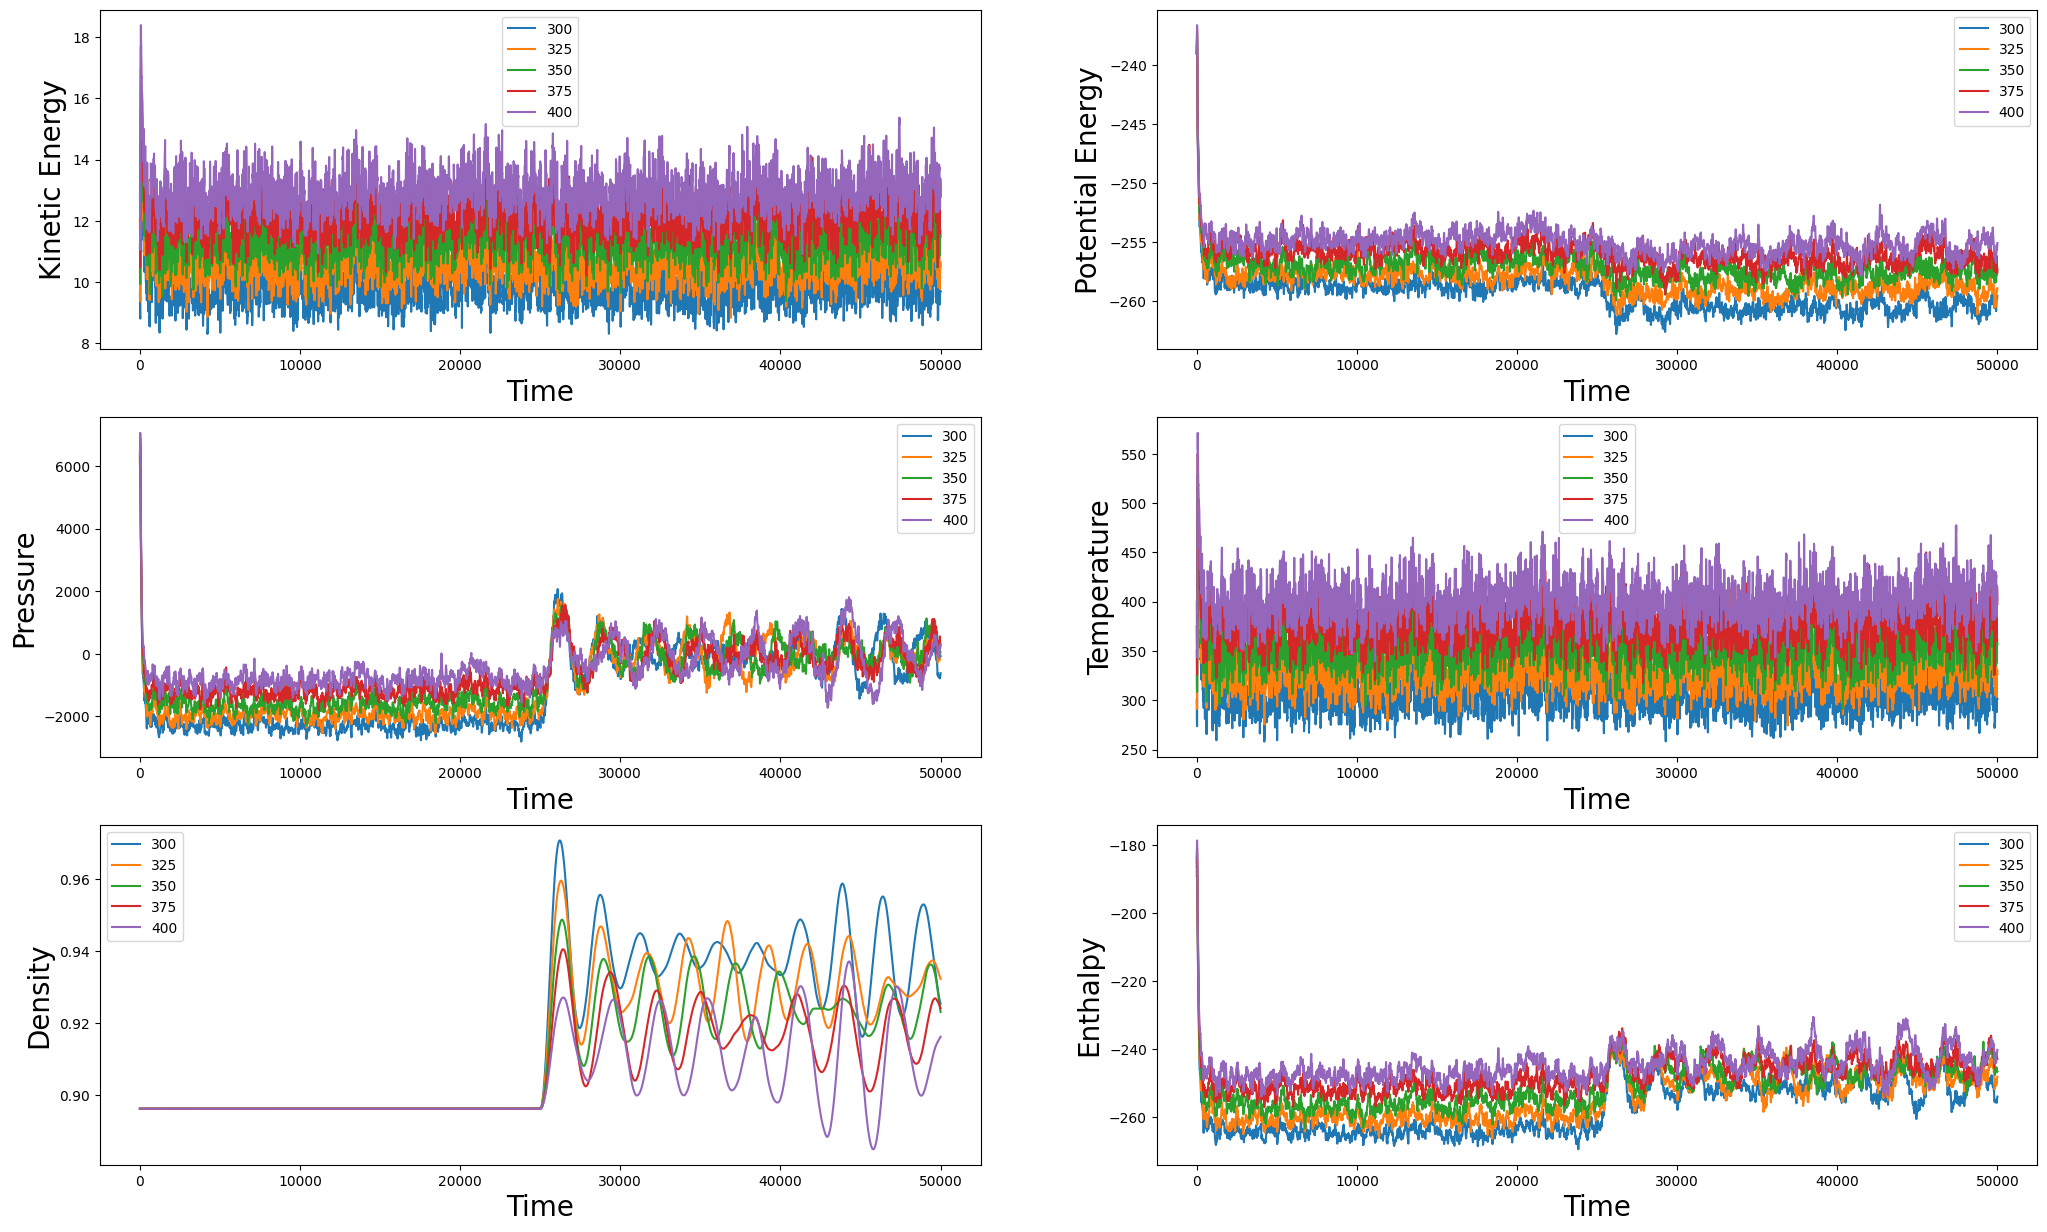

In [9]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/temp_press/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][:]), energy[tmp].T[n+1][:], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [19]:
%%bash
# create PLUMED input file
cat > "plumed.dat" << EOF
RESTART

LOAD FILE=../PRL-2017-PairEntropy/PairEntropy.cpp

PAIRENTROPY ...
 LABEL=s2
 ATOMS=1-250
 MAXR=0.7
 SIGMA=0.0125
... PAIRENTROPY

ENERGY LABEL=ene

VOLUME LABEL=vol

COMBINE ...
 ARG=ene,vol
 POWERS=1,1
 COEFFICIENTS=1.,0.060221409
 PERIODIC=NO
 LABEL=enthalpy
... COMBINE

COMBINE ...
 ARG=enthalpy
 POWERS=1
 COEFFICIENTS=0.004
 PERIODIC=NO
 LABEL=enthalpyPerAtom
... COMBINE

METAD ...
 LABEL=metad
 ARG=enthalpyPerAtom,s2
 SIGMA=0.2,0.1
 HEIGHT=2.5
 BIASFACTOR=30
 TEMP=350.0
 PACE=500
 GRID_MIN=-110,-8
 GRID_MAX=-90,-1
 GRID_BIN=500,500
 CALC_RCT
... METAD

PRINT STRIDE=500  ARG=* FILE=COLVAR

EOF

In [20]:
%%bash
cat > "restart.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart/restart.\${temperature}.\${p_id}.50000
include in.setup

# NPT

# timer           timeout 23:50:00 every 5000
reset_timestep  0
include         in.dump

fix             1 all plumed plumedfile plumed.dat outfile plumed.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run             500000 # 1 ns

EOF

In [22]:
%%bash
lmp -v tmp 350 -in restart.lmp

LAMMPS (23 Jun 2022 - Update 4)


../PRL-2017-PairEntropy/PairEntropy.cpp: In member function ‘virtual void PLMD::colvar::PairEntropy::calculate()’:
../PRL-2017-PairEntropy/PairEntropy.cpp:264:21: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
  264 |          if (minBin > (nhist-1)) minBin=nhist-1;
      |              ~~~~~~~^~~~~~~~~~~
../PRL-2017-PairEntropy/PairEntropy.cpp:266:21: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
  266 |          if (maxBin > (nhist-1)) maxBin=nhist-1;
      |              ~~~~~~~^~~~~~~~~~~


OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 350
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart/restart.${temperature}.${p_id}.50000
read_restart restart/restart.350.${p_id}.50000
read_restart restart/restart.350.0.50000
Reading restart file ...
  restart file = 23 Jun 2022, LAMMPS = 23 Jun 2022
  restoring atom style full from restart
  triclinic box = (0.1074693 0.1074693 0.1074693) to (21.892531 21.892531 21.892531) with tilt (0 0 0)
  1 by 1 by 1 MPI processor grid
  pair style ea